In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import cvxpy as cp
from cvxpy import multiply as mult

In [9]:
y = np.array([20.79, 20.79, 22.40, 22.67, 23.15, 23.35, 23.89,
              23.99, 24.02, 24.01, 25.14, 26.57, 28.49, 27.76,
              29.04, 29.88, 30.06])
x = np.array([194.5, 194.3, 197.9, 198.4, 199.4, 199.9,
              200.9, 201.1, 201.4, 201.3, 203.6, 204.6,
              209.5, 208.6, 210.7, 211.9, 212.2])
x = x - np.mean(x)
n = len(y)

In [ ]:
# most general EML
w = cp.Variable(n, nonneg=True)
beta0 = cp.Variable()
beta1 = cp.Variable()
constraints = [cp.sum(w) == 1, cp.sum(mult(w, y - beta0 - mult(beta1, x))) == 0,
               cp.sum(mult(mult(w, x), y - beta0 - mult(beta1, x))) == 0]
obj = cp.Maximize(cp.sum(cp.log(w)))
prob = cp.Problem(obj, constraints)
prob.solve(nlp=True, verbose=False, derivative_test='none', solver='IPOPT')

In [46]:
print("optimal beta:                      ", beta0.value, beta1.value)
print("standard regression cvoefficients: ", np.mean(y), x.T @ y / (x.T @ x))

optimal beta:                       25.058823529411757 0.5228924007846357
standard regression cvoefficients:  25.058823529411764 0.5228924007846478


### Compute and plot level curves of empirical likelihood 

In [40]:
# generate plot of log empirical likelihood as a function of slope and intercept
def log_eml(beta0_val, beta1_val):
    w = cp.Variable(n, nonneg=True)
    constraints = [cp.sum(w) == 1,
                   cp.sum(mult(w, y - beta0_val - mult(beta1_val, x))) == 0,
                   cp.sum(mult(mult(w, x), y - beta0_val - mult(beta1_val, x))) == 0]
    obj = cp.Maximize(cp.sum(cp.log(w)))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.MOSEK, verbose=False)
    return prob.value


slopes = np.linspace(0.4, 0.7, 100)
intercepts = np.linspace(24.65, 25.8, 100)
log_emls = np.zeros((len(intercepts), len(slopes)))
for i, b0_val in enumerate(intercepts):
    for j, b1_val in enumerate(slopes):
        log_emls[i, j] = log_eml(b0_val, b1_val)

### compute optimal intercept for given slope

In [ ]:
def log_eml_fixed_slope(beta1_val):
    w = cp.Variable(n, nonneg=True)
    beta0 = cp.Variable()
    constraints = [cp.sum(w) == 1,
                   cp.sum(mult(w, y - beta0 - mult(beta1_val, x))) == 0,
                   cp.sum(mult(mult(w, x), y - beta0 - mult(beta1_val, x))) == 0]
    obj = cp.Maximize(cp.sum(cp.log(w)))
    prob = cp.Problem(obj, constraints)
    prob.solve(nlp=True, verbose=False, derivative_test='none', solver='IPOPT',
               least_square_init_duals='no')
    return prob.value, beta0.value

slopes_fine = np.linspace(0.4, 0.7, 100)
log_emls_fixed_slope = np.zeros(len(slopes_fine))
beta0s_fixed_slope = np.zeros(len(slopes_fine))
for i, b1_val in enumerate(slopes_fine):
    log_emls_fixed_slope[i], beta0s_fixed_slope[i] = log_eml_fixed_slope(b1_val)

Total number of variables............................:       86
                     variables with only lower bounds:       34
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       71
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   8.1450806273723970e+01    8.1450806273723970e+01
Dual infeasibility......:   8.5519100109017910e-14    8.5519100109017910e-14
Constraint violation....:   7.7715611723760958e-16    7.7715611723760958e-16
Complementarity.........:   1.0000000309211085e-11    1.0000000309211085e-11
Overall NLP e

### comp

In [57]:
# compute optimal slope for fixed intercept
def log_eml_fixed_intercept(beta0_val):
    w = cp.Variable(n, nonneg=True)
    beta1 = cp.Variable()
    constraints = [cp.sum(w) == 1,
                   cp.sum(mult(w, y - beta0_val - mult(beta1, x))) == 0,
                   cp.sum(mult(mult(w, x), y - beta0_val - mult(beta1, x))) == 0]
    obj = cp.Maximize(cp.sum(cp.log(w)))
    prob = cp.Problem(obj, constraints)
    prob.solve(nlp=True, verbose=False, derivative_test='none', solver='IPOPT',
               least_square_init_duals='no')
    return prob.value, beta1.value

intercepts_fine = np.linspace(24.65, 25.8, 100)
log_emls_fixed_intercept = np.zeros(len(intercepts_fine))
beta1s_fixed_intercept = np.zeros(len(intercepts_fine))
for i, b0_val in enumerate(intercepts_fine):
    log_emls_fixed_intercept[i], beta1s_fixed_intercept[i] = log_eml_fixed_intercept(b0_val)

Total number of variables............................:       86
                     variables with only lower bounds:       34
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       71
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   8.0173634412288749e+01    8.0173634412288749e+01
Dual infeasibility......:   3.7044023168167329e-13    3.7044023168167329e-13
Constraint violation....:   8.3960616237277463e-16    8.3960616237277463e-16
Complementarity.........:   1.0000000294285548e-11    1.0000000294285548e-11
Overall NLP e

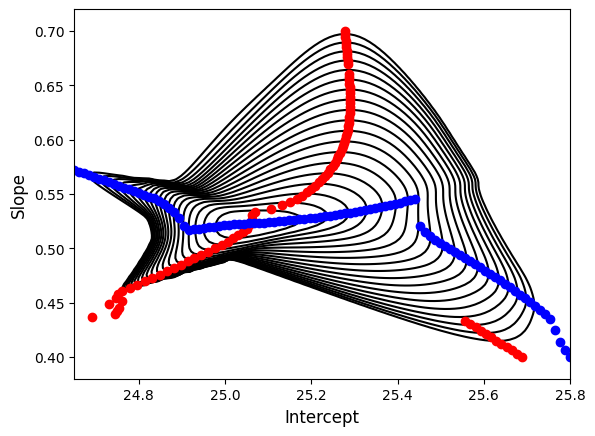

In [58]:
# plot level curves
minus_log_emls = -log_emls
minus_log_emls -= np.min(minus_log_emls)
Z = np.ma.masked_invalid(minus_log_emls)
B1, B0 = np.meshgrid(slopes, intercepts)
valid = np.isfinite(Z)
ZI = griddata((B0[valid], B1[valid]), Z[valid], (B0, B1), method='cubic')
levels = np.linspace(0, 30, 20)
plt.figure()
plt.contour(B0, B1, ZI, levels=levels, colors='black')

# plot intercepts for fixed slope
plt.plot(beta0s_fixed_slope, slopes_fine, 'ro')

# plot slopes for fixed intercept
plt.plot(intercepts_fine, beta1s_fixed_intercept, 'bo')


plt.xlim(24.65, 25.8)
plt.ylim(0.38, 0.72)




plt.xlabel("Intercept", fontsize=12)
plt.ylabel("Slope", fontsize=12)
plt.savefig("contour_plot.pdf")